In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11655392022132441744
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6086616425960245112
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5970913565927495806
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14640891840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13771144072203516836
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [ ]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 74 Sep  5 03:51 kaggle.json


In [ ]:
!pip install -q kaggle
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

 99% 707M/714M [00:03<00:00, 253MB/s]
100% 714M/714M [00:03<00:00, 242MB/s]


In [ ]:
!unzip lgg-mri-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_

In [ ]:
!rm -r lgg-mri-segmentation

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

# Any results you write to the current directory are saved as output.

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, add
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Set some parameters
im_width = 256
im_height = 256

In [ ]:
all_images = []
all_masks = glob('kaggle_3m/*/*_mask*')

for i in all_masks:
    all_images.append(i.replace('_mask',''))

print(all_images[:10])
print(all_masks[:10])

['kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_28.tif', 'kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_5.tif', 'kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_9.tif', 'kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_15.tif', 'kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_2.tif', 'kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_14.tif', 'kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_26.tif', 'kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_3.tif', 'kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_18.tif', 'kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_29.tif']
['kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_28_mask.tif', 'kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_5_mask.tif', 'kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_9_mask.tif', 'kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_15_mask.tif', 'kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_2_mask.tif', 'kaggle_3m/TCGA_HT_7

In [ ]:
barrier = 3000

train_files = all_images[:barrier]
mask_files = all_masks[:barrier]
test_images = all_images[:barrier]
test_masks = all_masks[:barrier]

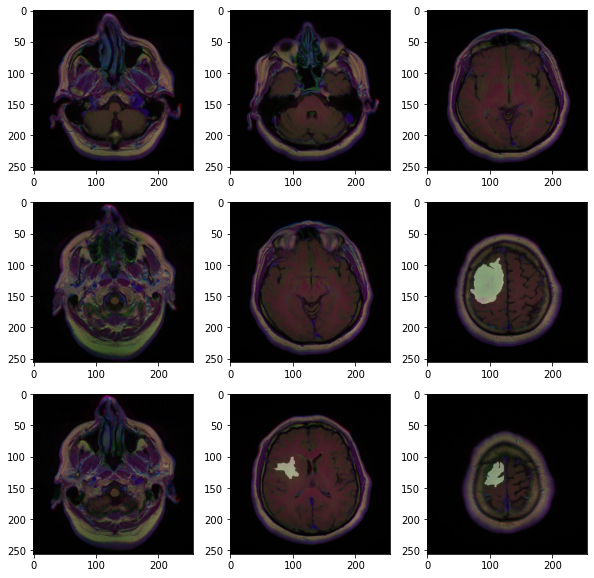

In [ ]:
# Lets plot some samples
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

In [ ]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return 1 - iou(y_true, y_pred)

def ms_ssim_loss(y_true, y_pred):
    return 1 - tf.image.ssim_multiscale(y_true, y_pred, max_val=1.0)

def mixed_loss(y_true, y_pred):
    return jac_distance(y_true, y_pred) + ms_ssim_loss(y_true, y_pred)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import *

def res_block(inputs,filter_size):
    """
    res_block -- Residual block for building res path
    
    Arguments:
    inputs {<class 'tensorflow.python.framework.ops.Tensor'>} -- input for residual block
    filter_size {int} -- convolutional filter size 
    
    Returns:
    add {<class 'tensorflow.python.framework.ops.Tensor'>} -- addition of two convolutional filter output  
    """
    # First Conv2D layer
    cb1 = Conv2D(filter_size,(3,3),padding = 'same',activation="relu")(inputs)
    # Second Conv2D layer parallel to the first one
    cb2 = Conv2D(filter_size,(1,1),padding = 'same',activation="relu")(inputs)
    # Addition of cb1 and cb2
    add = Add()([cb1,cb2])
    
    return add

def res_path(inputs,filter_size,path_number):
    """
    res_path -- residual path / modified skip connection
    
    Arguments:
    inputs {<class 'tensorflow.python.framework.ops.Tensor'>} -- input for res path
    filter_size {int} -- convolutional filter size 
    path_number {int} -- path identifier 
    
    Returns:
    skip_connection {<class 'tensorflow.python.framework.ops.Tensor'>} -- final res path
    """
    # Minimum one residual block for every res path
    skip_connection = res_block(inputs, filter_size)

    # Two serial residual blocks for res path 2
    if path_number == 2:
        skip_connection = res_block(skip_connection,filter_size)
    
    # Three serial residual blocks for res path 1
    elif path_number == 1:
        skip_connection = res_block(skip_connection,filter_size)
        skip_connection = res_block(skip_connection,filter_size)
    
    return skip_connection

def decoder_block(inputs, res, out_channels, depth):
    
    """
    decoder_block -- decoder block formation
    
    Arguments:
    inputs {<class 'tensorflow.python.framework.ops.Tensor'>} -- input for decoder block
    mid_channels {int} -- no. of mid channels 
    out_channels {int} -- no. of out channels
    
    Returns:
    db {<class 'tensorflow.python.framework.ops.Tensor'>} -- returning the decoder block
    """
    conv_kwargs = dict(
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        data_format='channels_last'  
    )
    
    # UpConvolutional layer
    db = UpSampling2D((2, 2), interpolation='bilinear')(inputs)
    db = concatenate([db, res], axis=3)
    # First conv2D layer 
    db = Conv2D(out_channels, 3, **conv_kwargs)(db)
    # Second conv2D layer
    db = Conv2D(out_channels, 3, **conv_kwargs)(db)

    if depth > 2:
        # Third conv2D layer
        db = Conv2D(out_channels, 3, **conv_kwargs)(db)

    return db

def TransResUNet(input_size=(512, 512, 1)):
    """
    TransResUNet -- main architecture of TransResUNet
    
    Arguments:
    input_size {tuple} -- size of input image
    
    Returns:
    model {<class 'tensorflow.python.keras.engine.training.Model'>} -- final model
    """
    
    # Input 
    inputs = Input(input_size)

    # VGG16 with imagenet weights
    encoder = VGG16(include_top=False, weights='imagenet', input_shape=input_size)
       
    # First encoder block
    enc1 = encoder.get_layer(name='block1_conv1')(inputs)
    enc1 = encoder.get_layer(name='block1_conv2')(enc1)
    enc2 = MaxPooling2D(pool_size=(2, 2))(enc1)
    
    # Second encoder block
    enc2 = encoder.get_layer(name='block2_conv1')(enc2)
    enc2 = encoder.get_layer(name='block2_conv2')(enc2)
    enc3 = MaxPooling2D(pool_size=(2, 2))(enc2)
    
    # Third encoder block
    enc3 = encoder.get_layer(name='block3_conv1')(enc3)
    enc3 = encoder.get_layer(name='block3_conv2')(enc3)
    enc3 = encoder.get_layer(name='block3_conv3')(enc3)
    center = MaxPooling2D(pool_size=(2, 2))(enc3)

    # Center block
    center = Conv2D(1024, (3, 3), activation='relu', padding='same')(center)
    center = Conv2D(1024, (3, 3), activation='relu', padding='same')(center)
    
    # classification branch
    cls = Conv2D(32, (3,3), activation='relu', padding='same')(center)
    cls = Conv2D(1, (1,1))(cls)
    cls = GlobalAveragePooling2D()(cls)
    cls = Activation('sigmoid', name='class')(cls)
    clsr = Reshape((1, 1, 1), name='reshape')(cls)
    
    # Decoder block corresponding to third encoder
    res_path3 = res_path(enc3,128,3)
    dec3 = decoder_block(center, enc3, 256, 3)
    
    # Decoder block corresponding to second encoder
    res_path2 = res_path(enc2,64,2)
    dec2 = decoder_block(dec3, enc2, 128, 2)
    
    # Final Block concatenation with first encoded feature 
    res_path1 = res_path(enc1,32,1)
    dec1 = decoder_block(dec2, enc1, 64, 1)

    # Output
    out = Conv2D(1, 1)(dec1)
    out = Activation('sigmoid')(out)
    out = multiply(inputs=[out,clsr], name='seg')
    
    # Final model
    model = Model(inputs=[inputs], outputs=[out, cls])
    
    return model

In [ ]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
from tensorflow.keras.applications.vgg16 import preprocess_input

def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask, label = adjust_data(img, mask)
        yield (img,[mask,label])

def adjust_data(img,mask):
    img = preprocess_input(img)
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    masks_sum = np.sum(mask, axis=(1,2,3)).reshape((-1, 1))
    class_lab = (masks_sum != 0) + 0.
    
    return (img, mask, class_lab)

In [ ]:
from sklearn.model_selection import KFold
import pandas

kf = KFold(n_splits = 5, shuffle=False)
df = pandas.DataFrame(data={"filename": train_files, 'mask' : mask_files})

df2 = df.sample(frac=1).reset_index(drop=True)

In [ ]:

train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

histories = []
losses = []
accuracies = []
dicecoefs = []
ious = []

EPOCHS = 40
BATCH_SIZE = 16

for k, (train_index, test_index) in enumerate(kf.split(df2)):
    train_data_frame = df2.iloc[train_index]
    test_data_frame = df2.iloc[test_index]
    
    train_gen = train_generator(train_data_frame, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
    test_gener = train_generator(test_data_frame, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
    model = TransResUNet(input_size=(im_height, im_width, 3))
    
    model.compile(optimizer=Adam(lr=5e-6), loss={'seg':dice_coef_loss, 'class':'binary_crossentropy'}, \
                      loss_weights={'seg':1, 'class':1}, metrics={'seg':[iou, dice_coef, 'binary_accuracy'], 'class':['accuracy']})
    model.summary()
    callbacks = [ModelCheckpoint(str(k+1) + '_unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]
    history = model.fit(train_gen,
                        steps_per_epoch=len(train_data_frame) / BATCH_SIZE, 
                        epochs=EPOCHS, 
                        callbacks=callbacks,
                        validation_data = test_gener,
                        validation_steps=len(test_data_frame) / BATCH_SIZE)
    
    model = load_model(str(k+1) + '_unet_brain_mri_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
    
    test_gen = train_generator(test_data_frame, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    results = model.evaluate(test_gen, steps=len(test_data_frame) / BATCH_SIZE)
    results = dict(zip(model.metrics_names, results))
    
    histories.append(history)
    accuracies.append(results['seg_binary_accuracy'])
    losses.append(results['seg_loss'])
    dicecoefs.append(results['seg_dice_coef'])
    ious.append(results['seg_iou'])

    break

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_7[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[1][0]               
__________________________________________________________________________________________________
max_pooling2d_11 (MaxPooling2D) (None, 128, 128, 64) 0           block1_conv2[1][0]               
_______________________________________________________________________________________

In [ ]:
print('accuracies : ', accuracies)
print('losses : ', losses)
print('dicecoefs : ', dicecoefs)
print('ious : ', ious)

print('-----------------------------------------------------------------------------')
print('-----------------------------------------------------------------------------')

print('average accuracy : ', np.mean(np.array(accuracies)))
print('average loss : ', np.mean(np.array(losses)))
print('average dicecoefs : ', np.mean(np.array(dicecoefs)))
print('average ious : ', np.mean(np.array(ious)))
print()

print('standard deviation of accuracy : ', np.std(np.array(accuracies)))
print('standard deviation of loss : ', np.std(np.array(losses)))
print('standard deviation of dicecoefs : ', np.std(np.array(dicecoefs)))
print('standard deviation of ious : ', np.std(np.array(ious)))

accuracies :  [0.9971939325332642]
losses :  [-0.8394320607185364]
dicecoefs :  [0.8399643301963806]
ious :  [0.7418811917304993]
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
average accuracy :  0.9971939325332642
average loss :  -0.8394320607185364
average dicecoefs :  0.8399643301963806
average ious :  0.7418811917304993

standard deviation of accuracy :  0.0
standard deviation of loss :  0.0
standard deviation of dicecoefs :  0.0
standard deviation of ious :  0.0


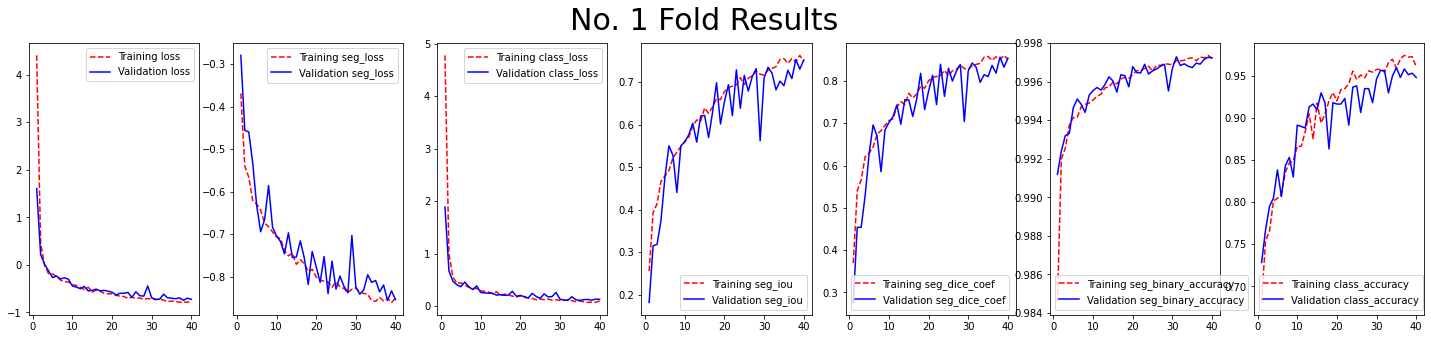

In [ ]:
for h, history in enumerate(histories):

    keys = history.history.keys()
    fig, axs = plt.subplots(1, len(keys)//2, figsize = (25, 5))
    fig.suptitle('No. ' + str(h+1) + ' Fold Results', fontsize=30)

    for k, key in enumerate(list(keys)[:len(keys)//2]):
        training = history.history[key]
        validation = history.history['val_' + key]

        epoch_count = range(1, len(training) + 1)

        axs[k].plot(epoch_count, training, 'r--')
        axs[k].plot(epoch_count, validation, 'b-')
        axs[k].legend(['Training ' + key, 'Validation ' + key])

[[0.4191834]]


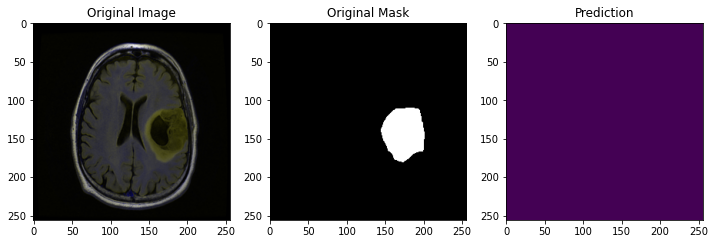

[[0.15348023]]


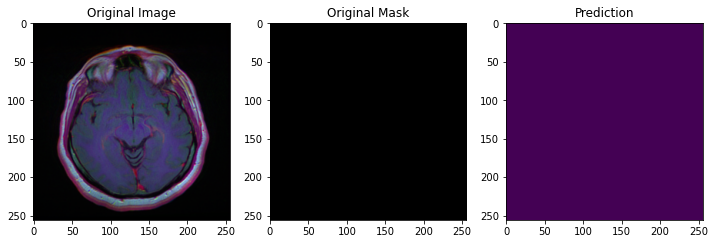

[[0.00032824]]


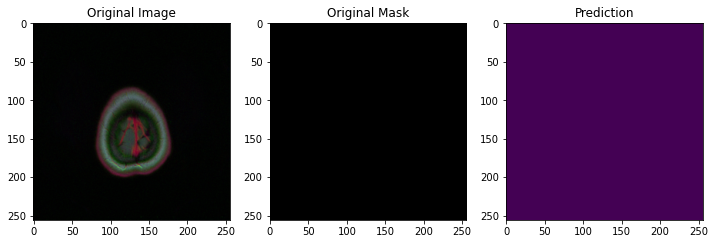

[[0.00018005]]


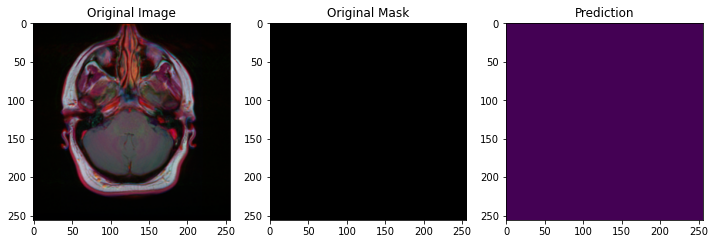

[[0.9939844]]


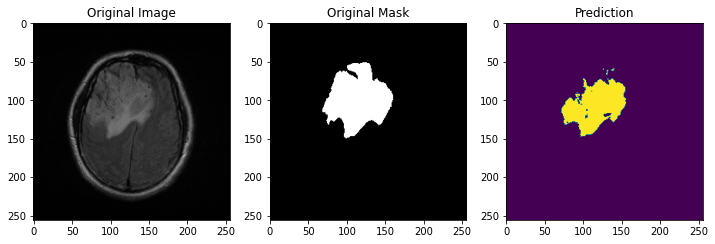

[[0.99999905]]


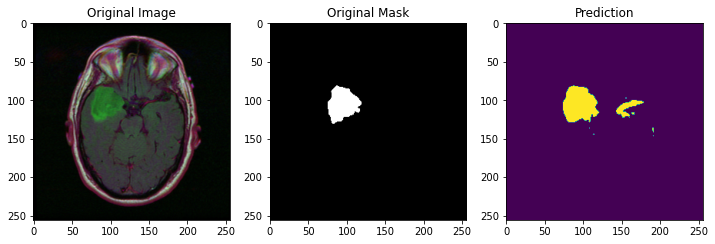

[[0.99992]]


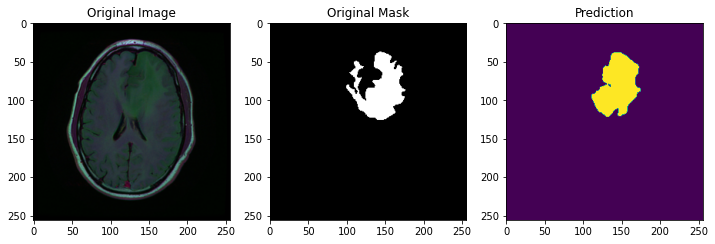

[[0.00855065]]


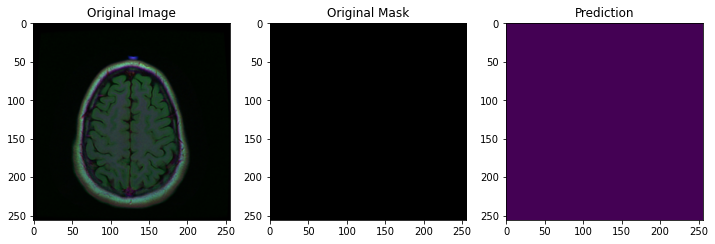

[[0.00019262]]


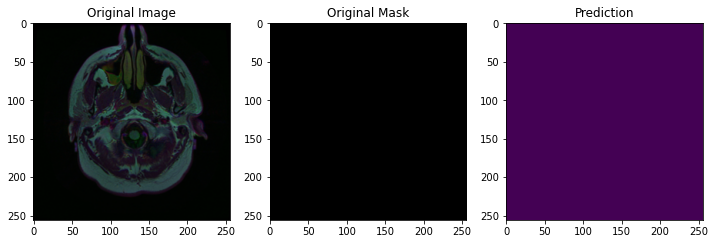

[[0.13788678]]


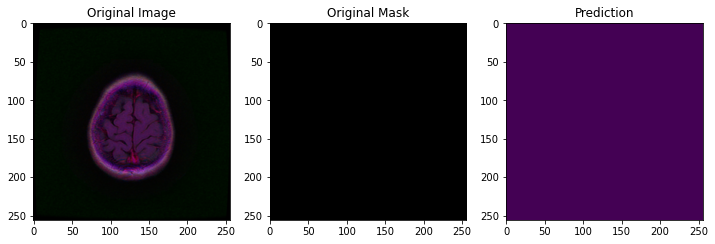

[[0.9893891]]


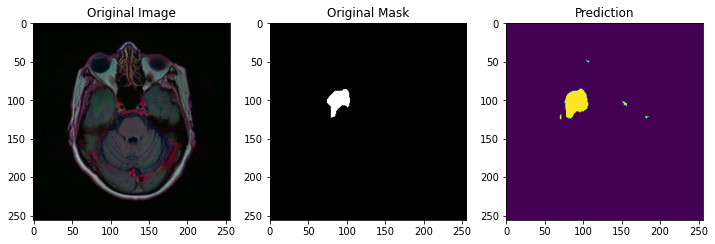

[[0.00383369]]


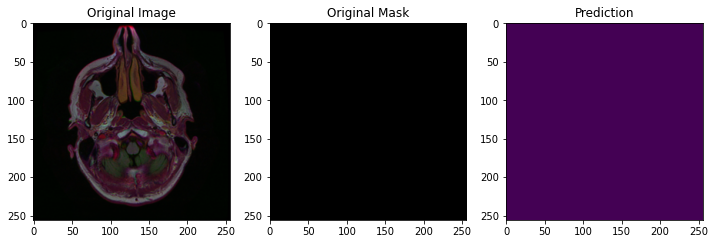

[[0.00540444]]


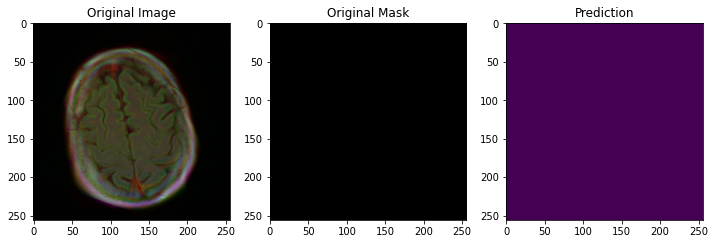

[[3.2546031e-06]]


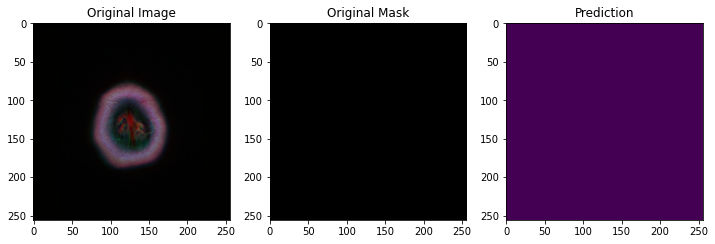

[[0.00772894]]


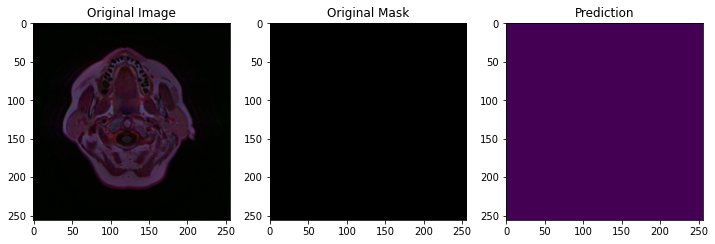

[[1.]]


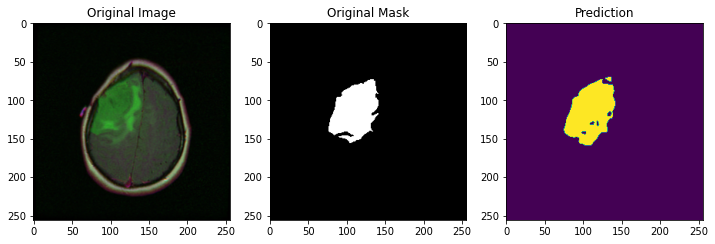

[[0.96154654]]


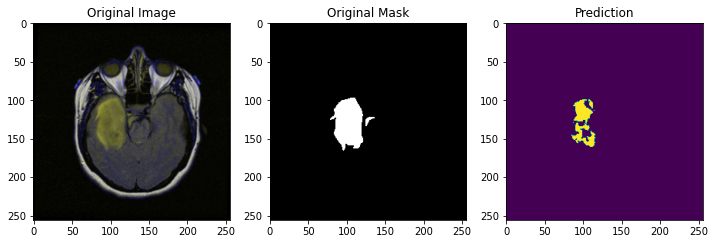

[[1.4951065e-14]]


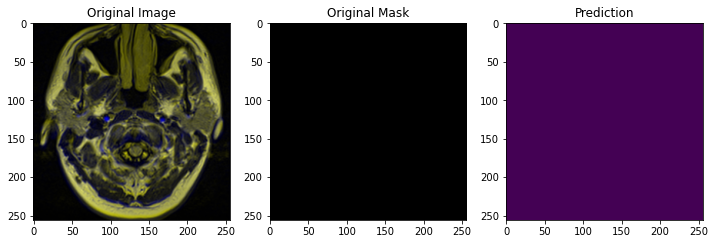

[[0.9999951]]


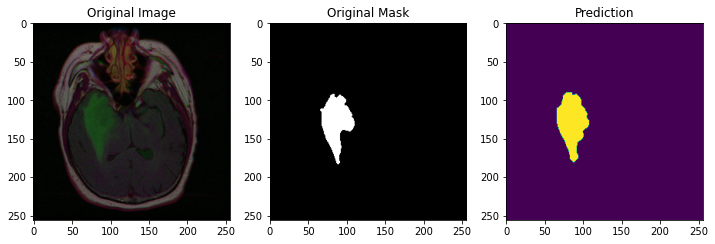

[[0.00405313]]


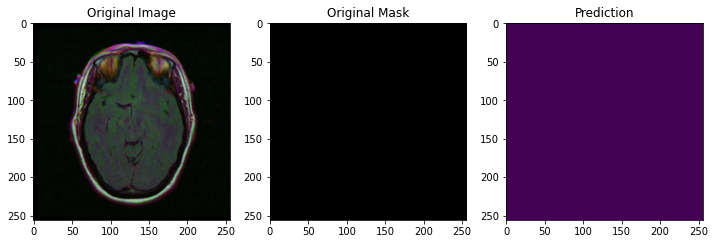

In [ ]:
for i in range(20):
    # index=np.random.randint(1,len(test_data_frame.index))
    index = 100 + i
    img = cv2.imread(test_data_frame['filename'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = preprocess_input(img)
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)
    print(pred[1])

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(cv2.imread(test_data_frame['filename'].iloc[index]))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(test_data_frame['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred[0]) > .5)
    plt.title('Prediction')
    plt.show()

In [ ]:
df = pandas.DataFrame(data={"filename": test_images, 'mask' : test_masks})

test_gen = train_generator(df, BATCH_SIZE,
                            dict(),
                            target_size=(im_height, im_width))
results = model.evaluate(test_gen, steps=len(test_data_frame) / BATCH_SIZE)
results = dict(zip(model.metrics_names, results))

Found 3000 validated image filenames.
Found 3000 validated image filenames.
38/37 [==============================] - 9s 240ms/step - loss: -0.8221 - seg_loss: -0.8737 - class_loss: 0.0516 - seg_iou: 0.7799 - seg_dice_coef: 0.8737 - seg_binary_accuracy: 0.9974 - class_accuracy: 0.9868


In [ ]:
print(results)

{'loss': -0.8221235871315002, 'seg_loss': -0.8737289905548096, 'class_loss': 0.05160544812679291, 'seg_iou': 0.7799496054649353, 'seg_dice_coef': 0.8737289905548096, 'seg_binary_accuracy': 0.9973670840263367, 'class_accuracy': 0.9868420958518982}
